In [4]:
import lightgbm as lgb
import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import seaborn as sns

In [5]:
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Seaborn version: 0.13.2
Matplotlib version: 3.10.3


In [12]:
filepath = '../../split_income_data'

### Loading Datasets

In [13]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [14]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [15]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Objective Function

In [6]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("number_trees", 10, 300)

    max_depth = trial.suggest_int("max_tree_depth", 3, 25)

    boosting_type = trial.suggest_categorical("boosting_type", ['gbdt', 'dart'])
    
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 0, 10)

    learning_rate = trial.suggest_float("learning_rate", 0, 1)
    l1_norm = trial.suggest_float("l1_norm", 0, 0.001)
    l2_norm = trial.suggest_float("l2_norm", 0, 0.001)

    lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity = -1, n_estimators=n_trees, boosting=boosting_type, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=l1_norm, reg_lambda=l2_norm, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq)
    trained_model = lgbm_model.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

#### Code Design

In [16]:
train[0][2 * 2 + 1].column = 'Maternal mortality ratio (national estimate per 100000 live births)'
validation[0][1].column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)


val_input_data = validation[0][0]
val_input_data['setting'] = val_input_data['setting'].astype("category")
val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

train_input_data = train[0][2 * 2]
train_input_data['setting'] = train_input_data['setting'].astype("category")
train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

#Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_input_data, train[0][2 * 2 + 1], val_input_data, validation[0][1]), n_trials=2)
best_model = lgb.LGBMRegressor(**study.best_params)
best_model.fit(train_input_data, train[0][2 * 2 + 1])

best_pred = best_model.predict(val_input_data)
best_val_loss = mean_squared_error(best_pred, validation[0][1])

best_pred_test = best_model.predict(test_data_x)
best_test_loss = mean_squared_error(best_pred_test, test_data_y)

[I 2025-07-20 18:18:50,308] A new study created in memory with name: no-name-832d9ad4-abe2-4f9f-8c00-c79fb7e8903f
[I 2025-07-20 18:18:50,508] Trial 0 finished with value: 11140.56109899367 and parameters: {'number_trees': 12, 'max_tree_depth': 25, 'boosting_type': 'gbdt', 'bagging_fraction': 0.8037037017991651, 'bagging_freq': 3, 'learning_rate': 0.44083514797807155, 'l1_norm': 0.00025116528749827727, 'l2_norm': 0.0008364932166986137}. Best is trial 0 with value: 11140.56109899367.
[I 2025-07-20 18:18:51,193] Trial 1 finished with value: 14130.03860744354 and parameters: {'number_trees': 118, 'max_tree_depth': 13, 'boosting_type': 'gbdt', 'bagging_fraction': 0.3744213102675306, 'bagging_freq': 6, 'learning_rate': 0.4235580516633216, 'l1_norm': 0.0007751307143550002, 'l2_norm': 0.0009494217487030815}. Best is trial 0 with value: 11140.56109899367.


In [15]:
import re 
special_cols = [col for col in train_input_data.columns if re.search(r'[\"\[\]\{\}\\:,]', col)]
print("Columns with problematic characters:", special_cols)

Columns with problematic characters: ['Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)', 'Mortality rate attributed to household and ambient air pollution, age-standardized, female (per 100,000 female population)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)', 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)', 'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)', 'Mortality rate, infant (per 1,000 live births)', 'Cause of death, by communicable disea

#### Code Implementation

In [7]:
output_dir = '../../split_income_models/lightgbm'

In [ ]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx != 2:
            continue
        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-20 18:27:09,024] A new study created in memory with name: no-name-f218ff84-5d5c-449e-a5f3-c63f726d71ca
[I 2025-07-20 18:27:09,666] Trial 0 finished with value: 11810.18815666651 and parameters: {'number_trees': 167, 'max_tree_depth': 5, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9546182519807583, 'bagging_freq': 8, 'learning_rate': 0.7174254620266519, 'l1_norm': 2.2882057149082867e-06, 'l2_norm': 0.00042021927486938815}. Best is trial 0 with value: 11810.18815666651.
[I 2025-07-20 18:27:09,834] Trial 1 finished with value: 14600.35769117945 and parameters: {'number_trees': 32, 'max_tree_depth': 8, 'boosting_type': 'gbdt', 'bagging_fraction': 0.46899977877220655, 'bagging_freq': 10, 'learning_rate': 0.8610400960247976, 'l1_norm': 0.0006772291932128885, 'l2_norm': 0.00012198507076029808}. Best is trial 0 with value: 11810.18815666651.
[I 2025-07-20 18:27:10,083] Trial 2 finished with value: 8269.458845833602 and parameters: {'number_trees': 99, 'max_tree_depth': 18, 'boost

Now looking at instances where data has been dropped due to the missing data thresholds

In [165]:
val_input_data = validation[0][0].copy()
train_input_data = train[0][0].copy()
columns_needed = val_input_data.columns.intersection(train_input_data.columns)
columns_needed

Index(['date', 'setting',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)',
       'Antiretroviral therapy coverage (% of adult males living with HIV)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)',
       'Mortality rate, infant (per 1,000 live births)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 15-59 (% of population ages 15-59)',
       'Cause of death, by injury, ages 15-59, female (% of female population ages 15-59)',
       ...
       'Unemployment with intermediate e

In [166]:
diff_columns = train_input_data.columns.difference(val_input_data.columns)
print(diff_columns)

Index([], dtype='object')


In [168]:
val_input_data[columns_needed]

,date,setting,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)",Antiretroviral therapy coverage (% of adult males living with HIV),"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)","Mortality rate, infant (per 1,000 live births)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 15-59 (% of population ages 15-59)","Cause of death, by injury, ages 15-59, female (% of female population ages 15-59)",...,Unemployment with intermediate education (% of total labor force with intermediate education) male,"Share of youth not in education, employment or training (% of youth population) female","Share of youth not in education, employment or training (% of youth population) male",Trained teachers in secondary education (% of total teachers) female,Trained teachers in secondary education (% of total teachers) male,Trained teachers in preprimary education (% of total teachers) female,Trained teachers in preprimary education (% of total teachers) male,Trained teachers in primary education (% of total teachers) female,Trained teachers in primary education (% of total teachers) male,income_num
0,2004.0,Armenia,NaN,NaN,NaN,0.0,NaN,22.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.499702,84.482758,3.0
1,2007.0,Singapore,NaN,NaN,NaN,NaN,NaN,2.3,NaN,NaN,...,3.640,NaN,NaN,99.268631,99.910049,NaN,NaN,99.436012,98.012512,4.0
2,2014.0,Suriname,NaN,NaN,NaN,29.0,NaN,18.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,2007.0,Armenia,NaN,NaN,NaN,7.0,NaN,19.2,NaN,NaN,...,22.070,44.868,31.125,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,1987.0,Kazakhstan,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,1985.0,Kazakhstan,NaN,NaN,NaN,NaN,NaN,49.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
487,2006.0,Kazakhstan,NaN,NaN,NaN,NaN,NaN,25.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
488,2016.0,Colombia,NaN,NaN,NaN,50.0,NaN,13.0,NaN,NaN,...,7.869,28.779,13.660,98.704247,97.556808,NaN,NaN,95.816727,91.585320,3.0
489,1991.0,Tajikistan,NaN,NaN,NaN,NaN,NaN,82.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [170]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx == 2:
            continue

        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-24 10:29:30,615] A new study created in memory with name: no-name-da30aaf5-c236-4e69-878d-51579631a081
[I 2025-07-24 10:29:32,419] Trial 0 finished with value: 35554.90830113373 and parameters: {'number_trees': 244, 'max_tree_depth': 17, 'boosting_type': 'gbdt', 'bagging_fraction': 0.43179560563140584, 'bagging_freq': 4, 'learning_rate': 0.7771188683992565, 'l1_norm': 0.0008951493822583321, 'l2_norm': 0.0005452313338980248}. Best is trial 0 with value: 35554.90830113373.
[I 2025-07-24 10:29:32,621] Trial 1 finished with value: 15159.761135664237 and parameters: {'number_trees': 14, 'max_tree_depth': 23, 'boosting_type': 'dart', 'bagging_fraction': 0.6859810051271209, 'bagging_freq': 3, 'learning_rate': 0.6716202267262643, 'l1_norm': 7.203763130627283e-05, 'l2_norm': 5.26202362792394e-05}. Best is trial 1 with value: 15159.761135664237.
[I 2025-07-24 10:29:34,190] Trial 2 finished with value: 12314.843414490786 and parameters: {'number_trees': 265, 'max_tree_depth': 6, 'boost

### Loading Models

In [6]:
output_dir = '../../split_income_models/lightgbm'

#### Test values for all models

In [7]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Missing Data Threshold Fold                         
Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
None                   1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN

In [35]:
test_data_y.iloc[0] + 5

Maternal mortality ratio (national estimate, per 100,000 live births)    72.0
Name: 0, dtype: float64

In [8]:
best_parameters = {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}

In [17]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")
        best_parameters[thresh_name].append(best_params)
        best_model = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(prediction, test_data_y)
        mae = mean_absolute_error(prediction, test_data_y)
        rmse = np.sqrt(mse)
        r2 = r2_score(prediction, test_data_y)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), 'MSE'] = mse
        test_stats.loc[(thresh_name, fold_num), 'MAE'] = mae
        test_stats.loc[(thresh_name, fold_num), 'RMSE'] = rmse
        test_stats.loc[(thresh_name, fold_num), 'R2'] = r2
        test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_77523/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_77523/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_77523/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [18]:
test_stats

MAPE        MAE           MSE        RMSE  \
Missing Data Threshold Fold                                                  
Threshold 85%          1     0.547298  47.682695   9220.638445   96.024156   
                       2     0.480129  43.396004   8964.716649   94.682188   
                       3     0.634595  48.512899  12890.695368  113.537198   
                       4     0.654236  51.148637  13266.467727  115.180153   
                       5     0.469717  40.203737   8973.901648    94.73068   
Threshold 95%          1     0.452743  36.990722   8000.533717   89.445703   
                       2     0.627229  46.811261  10406.644196  102.012961   
                       3     0.471952  41.120498   9355.138143   96.721963   
                       4     0.475682  40.840187   9769.749725   98.842044   
                       5     0.505446  35.608369   6822.421702   82.597952   
None                   1     0.465526  37.726197   8738.567693   93.480306   
                       2     0.416654   33.47689   8743.715419   93.507836   
                       3     0.459231  39.591058   9050.290474   95.133015   
                       4     0.435599  35.043739   7680.751851   87.639899   
                       5     0.460217  37.165222   8476.854675   92.069836   

                                   R2  
Missing Data Threshold Fold            
Threshold 85%          1     0.517633  
                       2     0.651585  
                       3     0.685131  
                       4     0.612891  
                       5     0.415333  
Threshold 95%          1     0.644284  
                       2     0.591624  
                       3     0.565624  
                       4     0.513316  
                       5     0.615942  
None                   1     0.578152  
                       2     0.351936  
                       3     0.560746  
                       4     0.594658  
                       5     0.597426

In [47]:
mean_summary = test_stats.groupby(level='Missing Data Threshold').mean()
mean_summary = mean_summary.astype('float')
mean_summary = mean_summary.round(2)
std_summary = test_stats.groupby(level='Missing Data Threshold').std()
std_summary = std_summary.astype('float')
std_summary = std_summary.round(2)

In [ ]:
# setting up the dataframe to hold summary of cross-fold validation results
summary_index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

summary_stats = pd.DataFrame(index=['Threshold 85%', 'Threshold 95%', 'None'], columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

for thresh_idx, thresh in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
    for metric_idx, metric in enumerate(['MAPE', 'MAE', 'MSE', 'RMSE', 'R2']):
        summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])

summary_stats

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_77523/2824869668.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_77523/2824869668.py:6: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])


,MAPE,MAE,MSE,RMSE,R2
Threshold 85%,0.447 +- 0.021,36.601 +- 2.383,8538.036 +- 520.481,92.366 +- 2.856,0.537 +- 0.104
Threshold 95%,0.557 +- 0.085,46.189 +- 4.355,10663.284 +- 2211.238,102.831 +- 10.553,0.577 +- 0.11
None,0.507 +- 0.07,40.274 +- 4.368,8870.897 +- 1445.227,93.924 +- 7.839,0.586 +- 0.05


#### Best Parameters

In [142]:
best_parameters[0]

{'number_trees': 127,
 'max_tree_depth': 17,
 'boosting_type': 'dart',
 'bagging_fraction': 0.21018895522828218,
 'bagging_freq': 8,
 'learning_rate': 0.17882980429748863,
 'l1_norm': 0.0008633354636498396,
 'l2_norm': 4.907953758093609e-05}

In [143]:
best_parameters[1]

{'number_trees': 146,
 'max_tree_depth': 25,
 'boosting_type': 'dart',
 'bagging_fraction': 0.40987432338890895,
 'bagging_freq': 6,
 'learning_rate': 0.0787409043384181,
 'l1_norm': 0.0007291015672717142,
 'l2_norm': 0.0009888658740959254}

In [144]:
best_parameters[2]

{'number_trees': 102,
 'max_tree_depth': 13,
 'boosting_type': 'gbdt',
 'bagging_fraction': 0.7698953325553642,
 'bagging_freq': 2,
 'learning_rate': 0.08418221272007202,
 'l1_norm': 0.0002608904816679338,
 'l2_norm': 0.000615420238356002}

In [145]:
best_parameters[3]

{'number_trees': 163,
 'max_tree_depth': 12,
 'boosting_type': 'gbdt',
 'bagging_fraction': 0.1874906013464987,
 'bagging_freq': 2,
 'learning_rate': 0.04931830811597937,
 'l1_norm': 3.78528601358768e-05,
 'l2_norm': 6.934817696467284e-05}

In [146]:
best_parameters[4]

{'number_trees': 149,
 'max_tree_depth': 20,
 'boosting_type': 'dart',
 'bagging_fraction': 0.4919186266612543,
 'bagging_freq': 8,
 'learning_rate': 0.2961168736178935,
 'l1_norm': 0.0008175662767019907,
 'l2_norm': 0.000607845505363139}

#### Visualisation

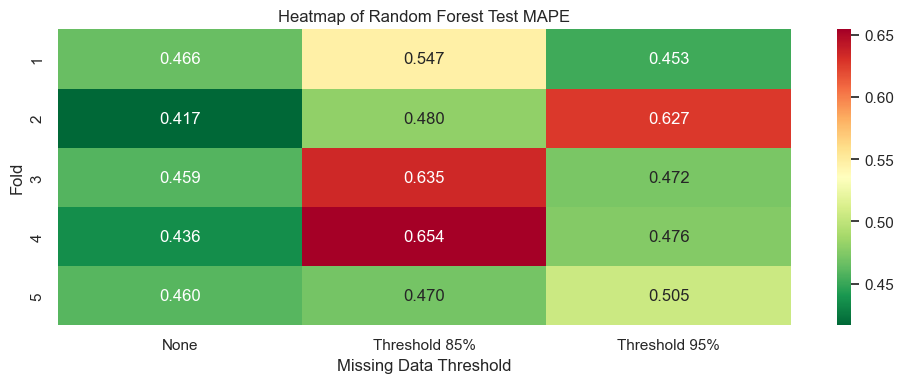

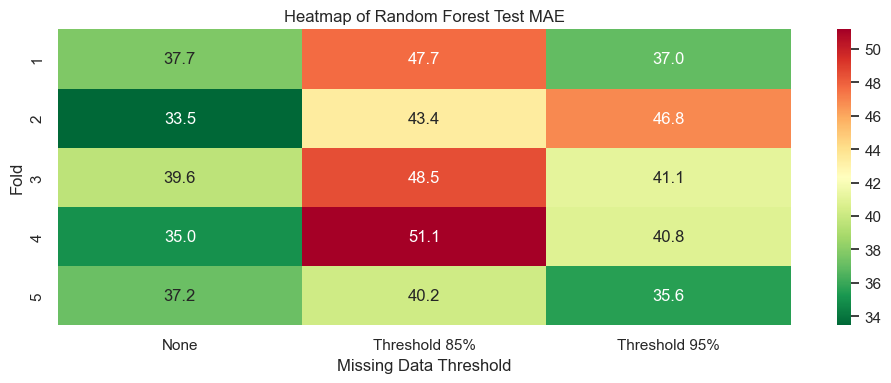

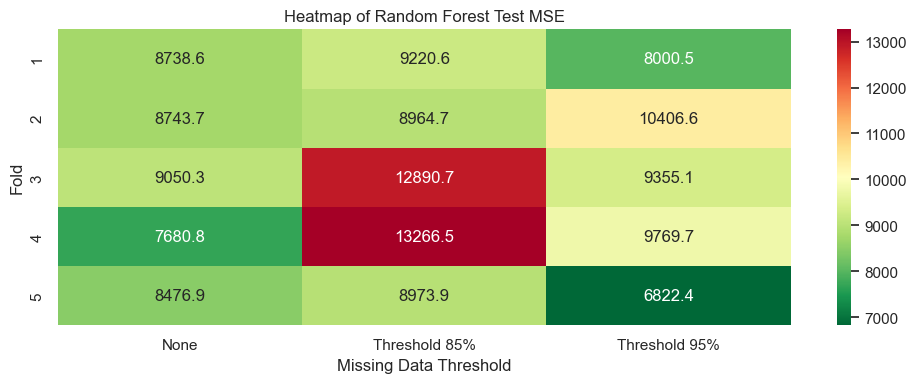

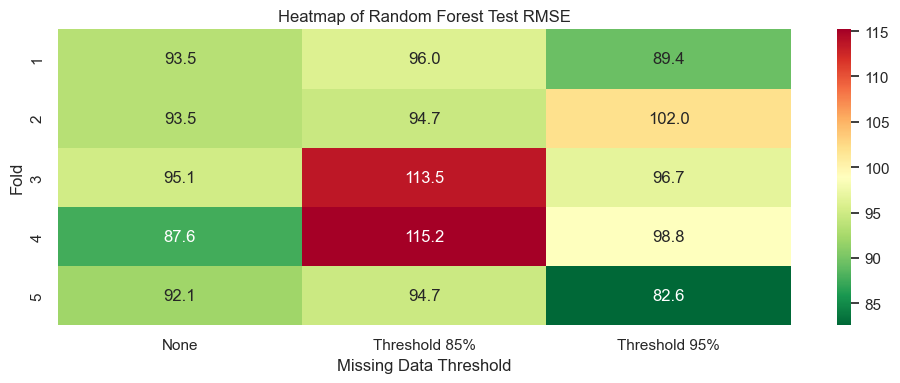

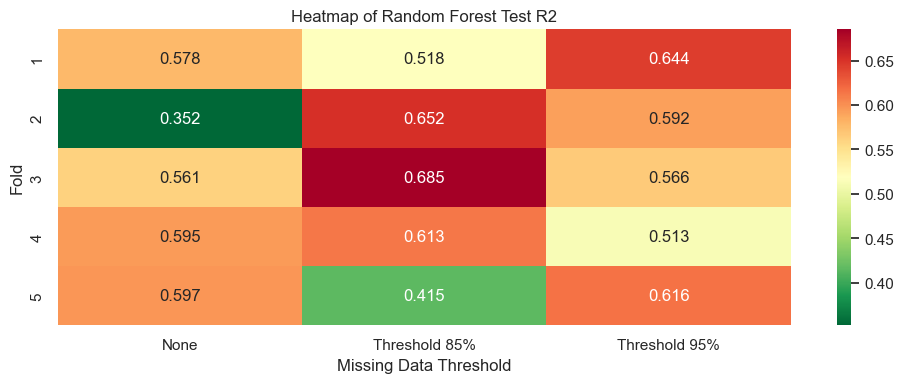

In [21]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [62]:
d.values

array([[0.54],
       [0.58],
       [0.59]])

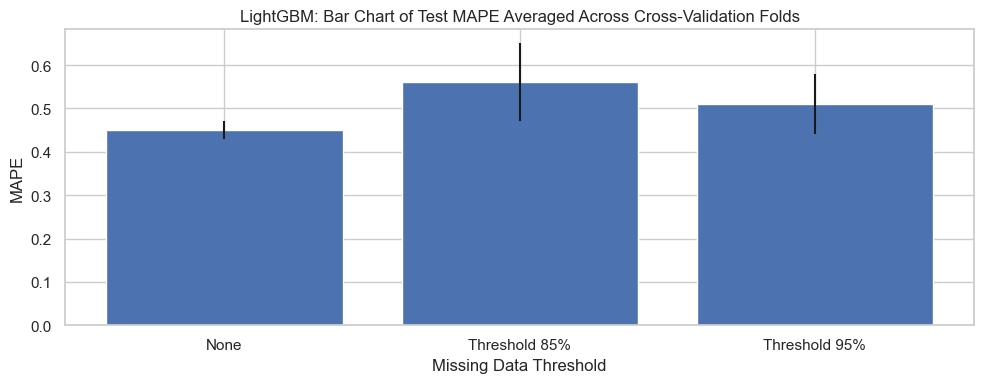

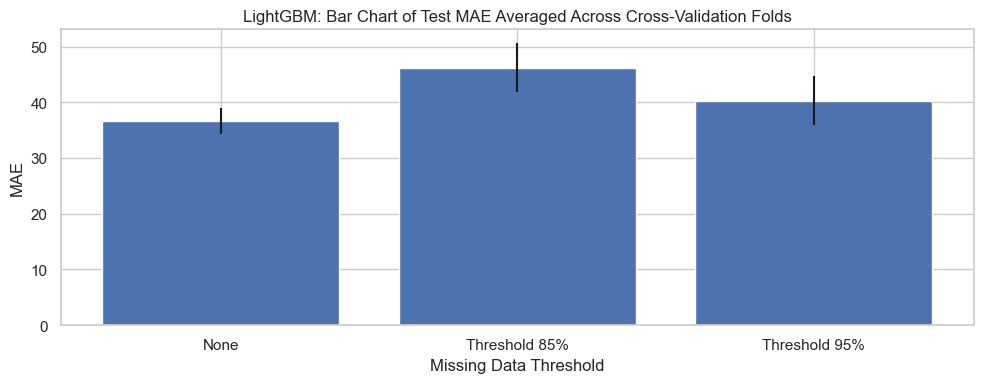

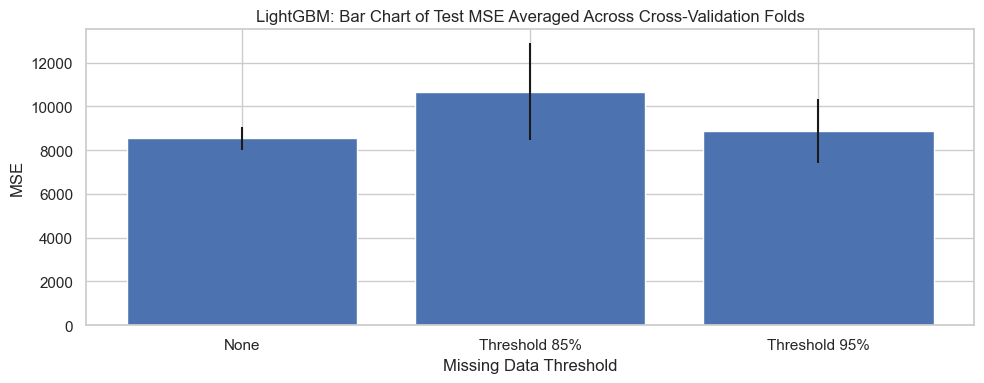

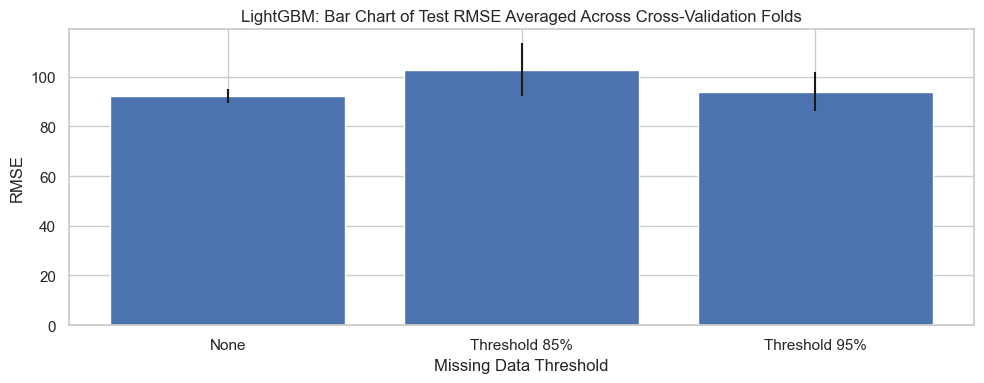

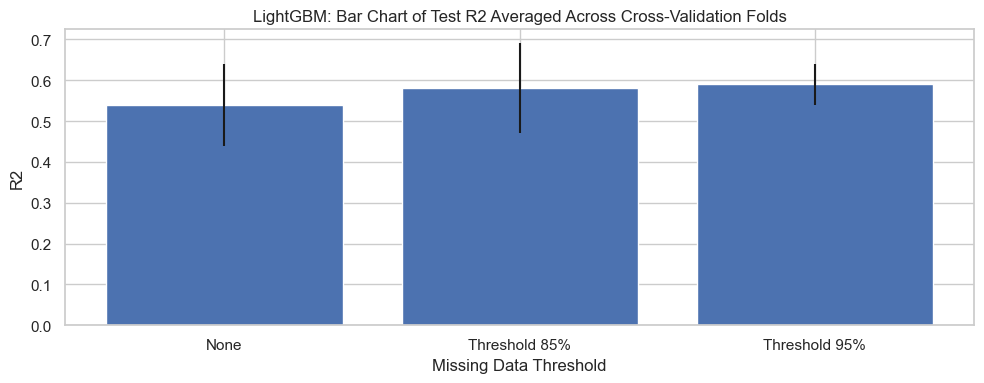

In [65]:
mean_data = mean_summary.astype(float)
std_data = std_summary.astype(float)

for metric in mean_data.columns:
    plt.figure(figsize=(10, 4))
    d_full = mean_data[metric]
    d = mean_data[metric].values
    e = std_data[metric].values
    plt.bar(d_full.index, d, yerr = e)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

In [66]:
mean_corr = mean_summary.corr()
mean_corr

,MAPE,MAE,MSE,RMSE,R2
MAPE,1.000000,0.982552,0.908998,0.905468,0.789203
MAE,0.982552,1.000000,0.970658,0.968605,0.661213
MSE,0.908998,0.970658,1.000000,0.999965,0.461414
RMSE,0.905468,0.968605,0.999965,1.000000,0.453952
R2,0.789203,0.661213,0.461414,0.453952,1.000000


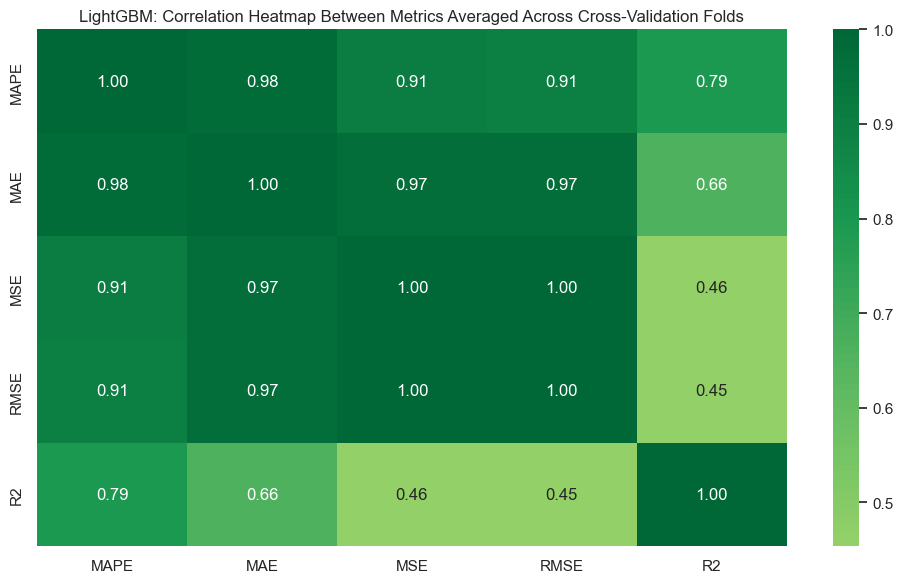

In [70]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds")
plt.tight_layout()
plt.show()

### extras